<a href="https://colab.research.google.com/github/sazio/MultiAgentCovid/blob/master/People_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd # data handling
from tqdm.notebook import tqdm # measuring for loops runtime
import matplotlib.pyplot as plt # plot 
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Import data from GDrive
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

In [ ]:
#path = "drive/MyDrive/MAS/Data/Output_GAMA/Data" # path to folder & files
path = "drive/MyDrive/MAS/Data/Output_GAMA/Data" # path to folder & files
people_path = path + "/People" # path to agents files , gama export
num_people = 30030 
#betas = [0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]
betas = [0.025, 0.05, 0.075, 0.1]

people_files = []

for i in tqdm(range(0,num_people)):
    people_files.append(people_path + "people" + str(i) + ".txt")

  0%|          | 0/30030 [00:00<?, ?it/s]

In [ ]:
def preprocess_people(people_file):

    DF_people = pd.read_csv(people_file, sep = ",", names = ["cycle","beta", "working_place","living_place","is_infected","is_immune","is_dead"])
    DF_people = DF_people[DF_people["cycle"] != "cycle"]
    DF_people = DF_people.reset_index(drop = True)

    DF_people["cycle"] = DF_people["cycle"].astype(np.int16)  # dtype conversion
    DF_people["beta"] = DF_people["beta"].astype(np.float32)
    DF_people = DF_people.replace({"is_infected":{"true":1, "false":0}})
    DF_people = DF_people.replace({"is_immune":{"true":1, "false":0}})
    DF_people = DF_people.replace({"is_dead":{"true":1, "false":0}}) 

    DF_people["is_susceptible"] = 1 - (DF_people.is_infected + DF_people.is_immune + DF_people.is_dead)

    mean_ =  DF_people.groupby(['beta', 'cycle'])['is_susceptible', 'is_immune', 'is_infected', 'is_dead'].mean()
    var_  =  DF_people.groupby(['beta', 'cycle'])['is_susceptible', 'is_immune', 'is_infected', 'is_dead'].var()

    return mean_, var_

In [ ]:
mean_0, var_0 = preprocess_people(people_files[0])

In [ ]:
mean = mean_0
var = var_0 
for file in tqdm(people_files[1:], total = len(people_files)):
    pivot_mean, pivot_var = preprocess_people(file)
    mean += pivot_mean
    var += pivot_var 

  0%|          | 0/30029 [00:00<?, ?it/s]

In [ ]:
aggr_people = mean.reset_index()
aggr_people["days"] = aggr_people["cycle"]/24
aggr_people_var = var.reset_index()
aggr_people_var["days"] = aggr_people_var["cycle"]/24
aggr_people_var["is_susceptible"] = aggr_people_var["is_susceptible"] /4 
aggr_people_var["is_immune"] = aggr_people_var["is_immune"]/4
aggr_people_var["is_infected"] = aggr_people_var["is_infected"]/4
aggr_people_var["is_dead"] = aggr_people_var["is_dead"]/4
aggr_people["std_infected"] = np.sqrt(aggr_people_var["is_infected"])

In [ ]:
aggr_people["lower_bound"] = aggr_people["is_infected"] - 3*aggr_people["std_infected"] # 3 sigma
aggr_people["upper_bound"] = aggr_people["is_infected"] + 3*aggr_people["std_infected"]

In [ ]:
aggr_people.head()

,beta,cycle,is_susceptible,is_immune,is_infected,is_dead,days,std_infected,lower_bound,upper_bound
0,0.025,0,31082.00,0.00,30.00,0.0,0.0,0.000000,30.000000,30.000000
1,0.025,24,31081.50,1.00,29.50,0.0,1.0,0.612372,27.662883,31.337117
2,0.025,48,31080.75,1.50,29.75,0.0,2.0,0.829156,27.262531,32.237469
3,0.025,72,31079.75,1.75,30.50,0.0,3.0,1.000000,27.500000,33.500000
4,0.025,96,31077.25,2.50,32.25,0.0,4.0,1.299038,28.352886,36.147114


In [ ]:
beta_0 = aggr_people[aggr_people.beta == aggr_people.iloc[0,0]] # corresponding to beta = 0.025...... 
beta_1 = aggr_people[aggr_people.beta == aggr_people.iloc[130,0]] # corresponding to beta = 0.05...... 
beta_2 = aggr_people[aggr_people.beta == aggr_people.iloc[250,0]] # corresponding to beta = 0.075...... 
beta_3 = aggr_people[aggr_people.beta == aggr_people.iloc[370,0]] # corresponding to beta = 0.1...... 

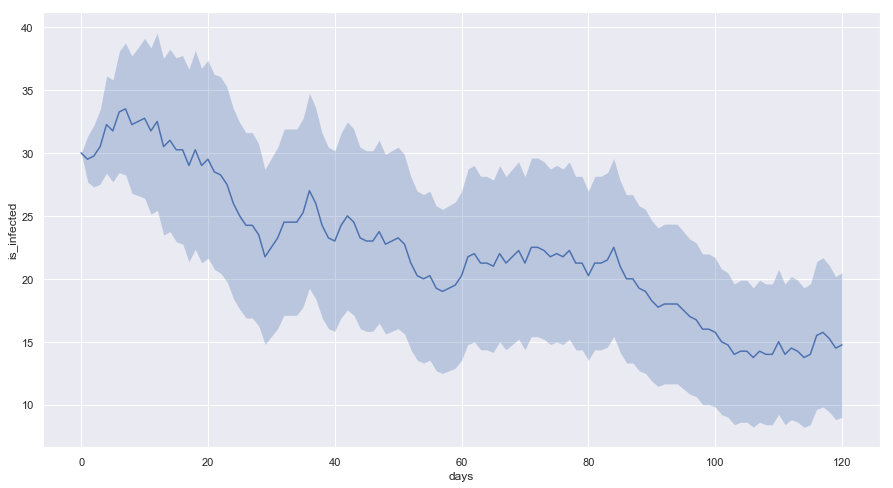

In [ ]:
sns.set_theme()
plt.figure(figsize = (15,8))
sns.lineplot(
    data= beta_0,
    x="days", y="is_infected" ,
    markers=True, dashes=False
)
plt.fill_between(beta_0.days, beta_0.lower_bound, beta_0.upper_bound, alpha=.3)
plt.show()

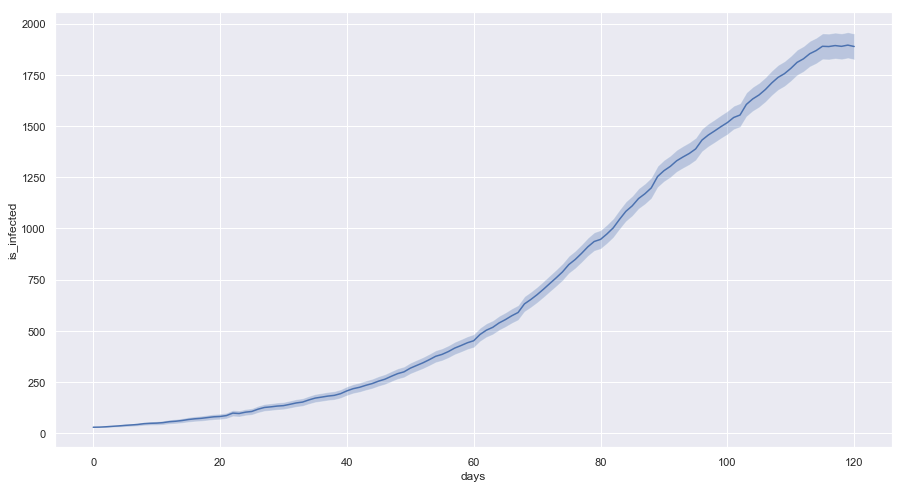

In [ ]:
sns.set_theme()
plt.figure(figsize = (15,8))
sns.lineplot(
    data= beta_1,
    x="days", y="is_infected" ,
    markers=True, dashes=False
)
plt.fill_between(beta_1.days, beta_1.lower_bound, beta_1.upper_bound, alpha=.3)
plt.show()

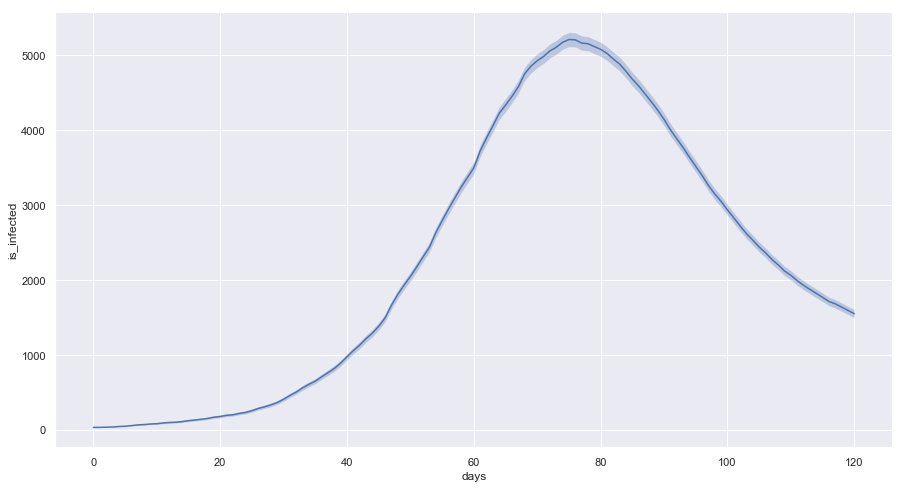

In [ ]:
sns.set_theme()
plt.figure(figsize = (15,8))
sns.lineplot(
    data= beta_2,
    x="days", y="is_infected" ,
    markers=True, dashes=False
)
plt.fill_between(beta_2.days, beta_2.lower_bound, beta_2.upper_bound, alpha=.3)
plt.show()

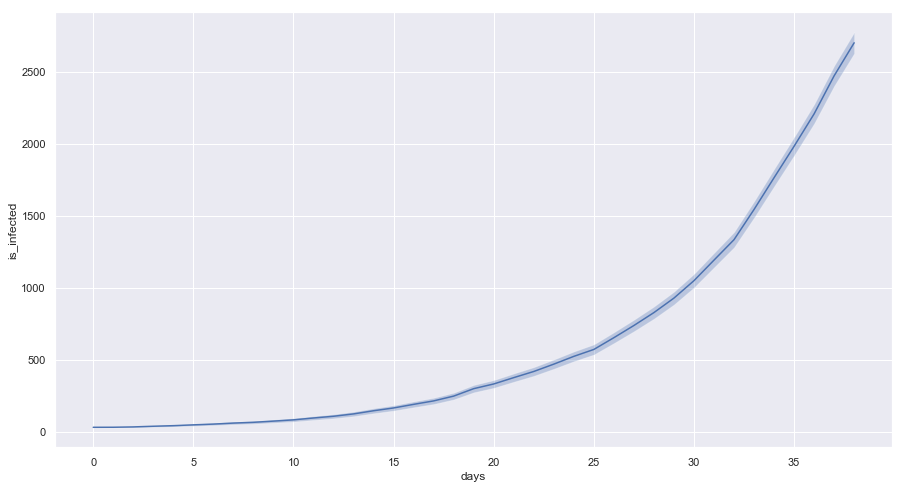

In [ ]:
sns.set_theme()
plt.figure(figsize = (15,8))
sns.lineplot(
    data= beta_3,
    x="days", y="is_infected" ,
    markers=True, dashes=False
)
plt.fill_between(beta_3.days, beta_3.lower_bound, beta_3.upper_bound, alpha=.3)
plt.show()

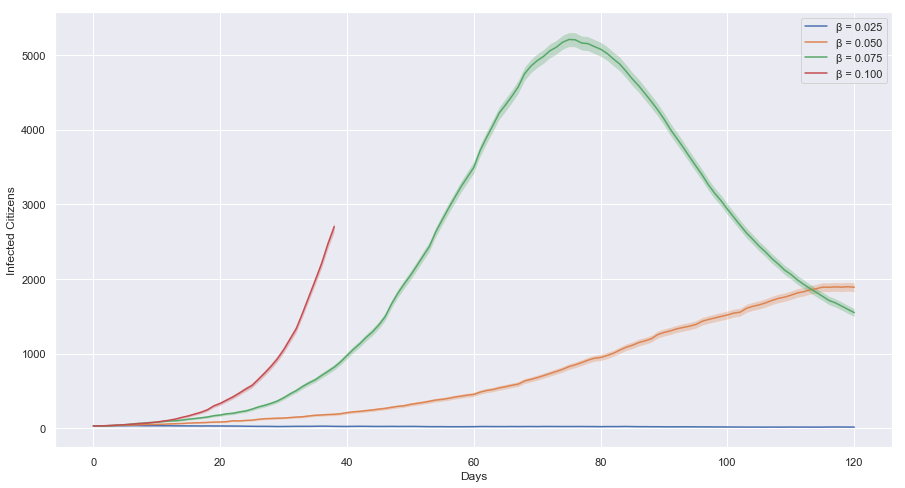

In [ ]:
## Beta == 0.025....
sns.set_theme()
plt.figure(figsize = (15,8))
a = sns.lineplot(
    data= beta_0,
    x="days", y="is_infected" ,
    markers=True, dashes=False
)
plt.fill_between(beta_0.days, beta_0.lower_bound, beta_0.upper_bound, alpha=.3)

## Beta == 0.05....
b = sns.lineplot(
    data= beta_1,
    x="days", y="is_infected" ,
    markers=True, dashes=False
)
plt.fill_between(beta_1.days, beta_1.lower_bound, beta_1.upper_bound, alpha=.3)

## Beta == 0.075....

c = sns.lineplot(
    data= beta_2,
    x="days", y="is_infected" ,
    markers=True, dashes=False
)
plt.fill_between(beta_2.days, beta_2.lower_bound, beta_2.upper_bound, alpha=.3)


## Beta == 0.1....

d = sns.lineplot(
    data= beta_3,
    x="days", y="is_infected" ,
    markers=True, dashes=False
)
plt.fill_between(beta_3.days, beta_3.lower_bound, beta_3.upper_bound, alpha=.3)
#custom_betas = [beta_0.days, beta_1.days, beta_2.days, beta_3.days]
#plt.legend(custom_betas, ["$\beta = 0.025$","$\beta = 0.05$","$\beta = 0.075$","$\beta = 0.1$" ])
d.legend(labels = ["β = 0.025","β = 0.050","β = 0.075","β = 0.100" ])
plt.xlabel("Days")
plt.ylabel("Infected Citizens")
#plt.savefig("betas_evolution.png", dpi = 600)
plt.show()